In [13]:
from spectral_decomposition import spectrum

def generate_data(random_state = 42):
    data = spectrum(
        sampling_rate=1000,
        duration=30,
        aperiodic_exponent=2.0,
        aperiodic_offset=2.0,
        knee=200,
        peaks=[{'freq':12, 'amplitude': 1.0, 'sigma': 2.0}],
        average_firing_rate=0.0,
        random_state=random_state,
        direct_estimate=True
    )
    return data

data = generate_data()
data_td = data.time_domain.combined_signal
data_fd = data.frequency_domain

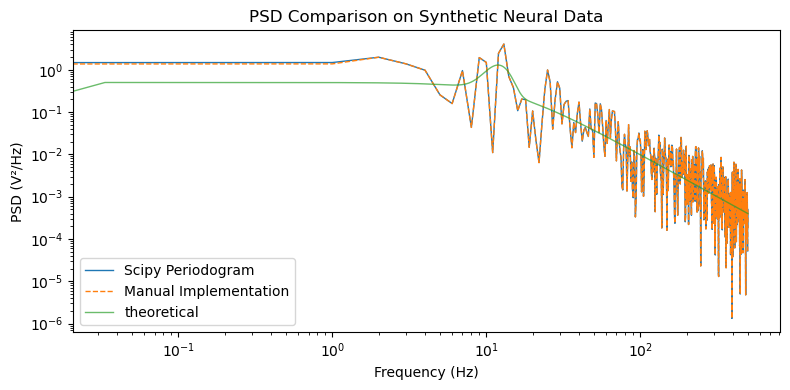

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram, windows

# ---- Your PSD functions ----
def single_taper_psd(signal, window_length_sec, taper_shape, fs=1000):
    N = int(fs * window_length_sec)
    x = signal[-N:]  # obtain last chunk
    freqs, psd = periodogram(x, fs=fs, window=taper_shape, scaling='density', return_onesided=True)
    # drop nyquist bin
    if freqs[-1] == fs / 2:
        freqs = freqs[:-1]
        psd = psd[:-1]
    return freqs, psd

def single_taper_no_welch(signal, window_length, taper_shape, fs=1000):
    """
    Args: 
    - signal: signal, time domain 
    - window_length: in seconds
    - taper_shape: string, desired taper
    - fs: sampling frequency, default = 1000

    Returns:
    - freqs: positive frequencies
    - psd: estimated power spectral density for positive frequencies (doubled)
    """
    
    N = int(window_length * fs)  # number of samples in window
    x = signal[-N:] # retrive last chunk
    window = windows.get_window(taper_shape, N)
    U = (1/N) * np.sum(window ** 2)

    tapered = x * window
    fft_result = np.fft.rfft(tapered, n = N) # rfft only returns nonnegative frequencies
    psd = (np.abs(fft_result)**2) / (fs * N * U)

    # double the power except for 0
    psd[1:] *= 2

    freqs = np.fft.rfftfreq(N, d=1/fs)

    # drop nyquist if present; only true if N is even
    if freqs[-1] == fs / 2:
        freqs = freqs[:-1]
        psd = psd[:-1]

    return freqs, psd

# ---- Use your data generator ----
data = generate_data()
data_td = data.time_domain.combined_signal  # time-domain signal
fs = 1000
window_length_sec = 1.0  # analyze last 1 second of data

# ---- Compute PSDs ----
f1, psd1 = single_taper_psd(data_td, window_length_sec, 'hann', fs)
f2, psd2 = single_taper_no_welch(data_td, window_length_sec, 'hann', fs)

freq_theo, psd_theo = data_fd.frequencies, data_fd.combined_spectrum

# ---- Plot ----
plt.figure(figsize=(8, 4))
plt.loglog(f1, psd1, label='Scipy Periodogram', linewidth=1)
plt.loglog(f2, psd2, '--', label='Manual Implementation', linewidth=1)
plt.loglog(data_fd.frequencies, data_fd.combined_spectrum, linewidth=1, alpha=0.7, label='theoretical')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD (V²/Hz)')
plt.title('PSD Comparison on Synthetic Neural Data')
plt.legend()
plt.tight_layout()
plt.show()